Deze slides zijn gebaseerd op:

- Hoofdstuk 17 van *Deep Learning in Python" van F. Choliet
- *Fischer, A., & Igel, C. (2012). An introduction to restricted Boltzmann machines. In Progress in Pattern Recognition, Image Analysis, Computer Vision, and Applications: 17th Iberoamerican Congress, CIARP 2012, Buenos Aires, Argentina, September 3-6, 2012. Proceedings 17 (pp. 14-36). Springer Berlin Heidelberg.*
- *Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.*
- *Kingma, D. P., & Welling, M. (2019). An introduction to variational autoencoders. Foundations and Trends® in Machine Learning, 12(4), 307-392.*
- *White, T. (2016). Sampling generative networks. arXiv preprint arXiv:1609.04468.*

De code is aangepast van https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter17_image-generation.ipynb

Voor deze code is een keras 3.13 + pytorch environment nodig, zie DLO voor **requirements_keras3_13.txt**.

---

#### Planning

9. Bayesiaanse kansrekening en statistiek
10. Graphical networks
11. (Restricted) Boltzman machines en Belief networks
12. PCA en auto-encoders

<hr>

Kerstvakantie

<hr>

13. **Variational auto-encoders** (datapunt)
14. Denoising $U$-nets
15. Stable Diffusion

(Onder voorbehoud)

---

#### Inhoud

- Herhaling -- Restricted Boltzmann Machines
- Non-Bernoulli RBMs
- Vartiational Auto-Encoders
- Voorbeeld: VAE op MNIST
- Voorbeeld: Genereren regendata
- Voorbeeld: Richtingen in latent space
- Samenvatting

---

#### Herhaling -- Restricted Boltzmann Machines

Eerder definieerde we een Restricted Boltzmann Machine als een *undirected graphical model*, met:

:::: {.columns}
::: {.column width="50%"}

- Visible nodes
- Hidden nodes
- Alleen verbindingen tussen visible en hidden nodes

In het geval van een *Bernoulli RBM* 

$(v_i, h_j \in \{0,1\})$ beschreven we de kansverdeling in termen van een energie:

$$
p(\vec{v}, \vec{h}) = \frac{1}{Z} e^{-E(\vec{v}, \vec{h})}
$$
met
$$
E(\vec{v}, \vec{h}) = -\vec{a}\cdot\vec{v} - \vec{b}\cdot \vec{h} - \vec{v} \cdot {\bf W} \vec{h}
$$
:::
::: {.column width="50%}

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Restricted_Boltzmann_machine.svg/256px-Restricted_Boltzmann_machine.svg.png" alt="Restricted Boltzmann machine.svg" width="75%">
^[Bron: By Qwertyus - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=22717044]

:::
::::

---

#### Herhaling -- Restricted Boltzmann Machines

We stelden toen dat


$$
p(h_j = 1 | \vec{v}) = \sigma(b_j + \sum v_i W_{ij})
$$
en
$$
p(v_i = 1 | \vec{h}) = \sigma(a_i + \sum W_{ij} h_j)
$$
met $\sigma(x) = 1/(1+e^{-x})$ de gebruikelijke sigmoid functie.

Dit doet misschien vermoeden dat $\sigma(x)$ hier een soort "activatiefunctie" is, die vergelijkbaar met neurale netwerken vrij te kiezen is.


**Dat is niet zo!**


De vorm van deze voorwaardelijke kansverdelingen is rechtstreeks af te leiden uit de aanname dat $v_i, h_i \in \{0,1\}$.

---

#### Herhaling -- Restricted Boltzmann Machines

Om dit te begrijpen gaan we even kijken naar een heel erg simpele *Bernoulli* RBM met één visible node, en één hidden node. De toestandsruimte bestaat nu uit vier gebeurtenissen met bijbehorden kansen, deze kansen gaan we als volgt coderen:

1. $v = 0, h = 0, \quad p(0,0) = e^0 / Z$
2. $v = 1, h = 0, \quad p(1,0) = e^a / Z$
3. $v = 0, h = 1, \quad p(0,1) = e^b / Z$
4. $v = 1, h = 1, \quad p(1,1) = e^{a + b + W} / Z$

Gecombineerd geeft dit
$$
p(v,h) = e^{av + bh + vWh} / Z.
$$

---

#### Herhaling -- Restricted Boltzmann Machines

In dit simpele geval kunnen we zelfs $Z$ expliciet uitrekenen
$$
Z = \sum_{v=0}^1 \sum_{h=0}^1 e^{av + bh + vWh} = 1 + e^a + e^b + e^{a + b + W}
$$
maar dit is eigenlijk niet nodig en in het algemeen bevat deze som $2^{n+m}$ termen.

---

#### Herhaling -- Restricted Boltzmann Machines

We kunnen nu de marginale kansverdelingen berekenen

:::: {.columns}
::: {.column width="50%"}
$$
\begin{aligned}
p(v) &= \sum_{h=0}^1 p(v,h) \\
&= \sum_{h=0}^1 e^{av +bh + vWh} / Z \\
&= (e^{av} + e^{av + b + vW}) / Z,
\end{aligned}
$$
:::
::: {.column width="50%"}
$$
\begin{aligned}
p(h) &= \sum_{v=0}^1 p(v,h) \\
&= \sum_{v=0}^1 e^{av +bh + vWh} / Z \\
&= (e^{bh} + e^{a + bh + Wh}) / Z.
\end{aligned}
$$
:::
::::

---

#### Herhaling -- Restricted Boltzmann Machines

En hieruit kunnen we de voorwaardelijke kansverdelingen berekenen

$$
\begin{aligned}
p(v = 1 | h) &= \frac{p(v = 1, h)}{p(h)} \\
&= \frac{e^{a + bh + Wh} / Z}{(e^{bh} + e^{a + bh + Wh})/Z} \\
&= \frac{e^{a + bh + Wh}}{e^{bh} + e^{a + bh + Wh}} \cdot \frac{e^{-(a + bh + Wh)}}{e^{-(a + bh + Wh)}} \\
&= \frac{1}{1 + e^{-(a + Wh)}} = \sigma(a + Wh)
\end{aligned}
$$
en met een vergelijkbare berekening zien we dat $p(h = 1 | v) = \sigma(b + vW)$. 

In de algemene setting met meerdere *visible* en *hidden* nodes is deze berekening wat complexer, maar bevat de zelfde elementen.

---

#### Non Bernoulli RBMs

Stel we willen dit model wat veralgemeniseren

- We houden één *visible* en één *hidden* node, $v$ en $h$
- Maar i.p.v. Bernoulli verdeelde $v$ en $h$ zijn deze nu normaal verdeeld

Probleem!

- In plaats van vier $\{0,1\} \times \{0,1\}$ toestanden bestaat onze toestandsruimte nu uit oneindig $\mathbb{R} \times \mathbb{R}$ gebeurtenissen.
- De allereerste stap van de vorige berekening gaat dus al mis

Onze kansverdeling $p(v,h)$ word niet meer gedefinieerd door drie nog te bepalen getallen $a$, $b$, en $W$ die onze *likelihood* maximaliseren, maar door onbekende functies.

Het wiskundige vakgebied waar we een onbekende functie zoeken die iets maximaliseerd, wordt ook wel *calculus of variations* genoemd. Is dit vervolgens gebaseerd op data, dan spreekt men van *variational inference*.

---

#### Variational Auto Encoders

Het artikel^[Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.] van Kingma & Welling dat de VAE introduceerde ging uit van de volgende standpunten:

:::: {.columns}
::: {.column width="70%"}

- Een graphical model
  + Continue of discrete data $\vec{x}$
  + Gegenereerd door latente variabelen $\vec{z}$
  + De *prior* verdeling voor $\vec{z}$ is een geparametriseerde kansverdling (meestal een (standaard) normaalverdeling)
- Geen versimpelende aannames (zoals bij RBM's)
  + De echte *posterior* verdeling is *intractable* (onmogelijk te berekenen)
- Voldoende veel data dat algoritmes zoals MCMC niet praktisch zijn

:::
::: {.column width="30%"}
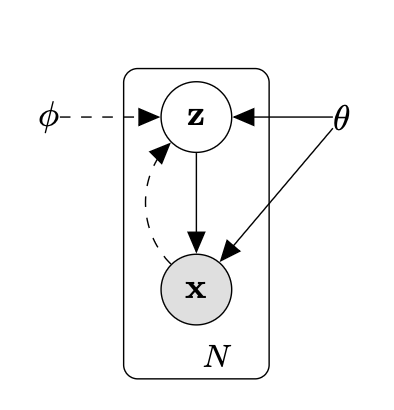
:::
::::

---

#### Variational Auto-Encoders

In een *variational auto-encoder* (VAE) worden de *visible* nodes als $\vec{x}$ genoteerd en de *hidden/latent* nodes als $\vec{z}$.


:::: {.columns}
::: {.column width="50%"}
- De voorwaardelijke kansverdeling $p(\vec{z} | \vec{x})$ kennen we niet, we leren een benadering $q(\vec{z} | \vec{x})$ van deze verdeling met een neuraal netwerk, een zgn. *Encoder*
$$
\begin{aligned}
\mu, \ln \sigma &= Encoder(\vec{x}), \\
q(\vec{z} | \vec{x}) &\sim Normal(\mu, \sigma^2).
\end{aligned}
$$
- Vergelijkbaar leren we de voorwaardelijke kansverdeling $p(\vec{x} | \vec{z})$ met een *Decoder*
$$
p(\vec{x} | \vec{z}) = Decoder(\vec{z}).
$$
:::
::: {.column width="50%"}

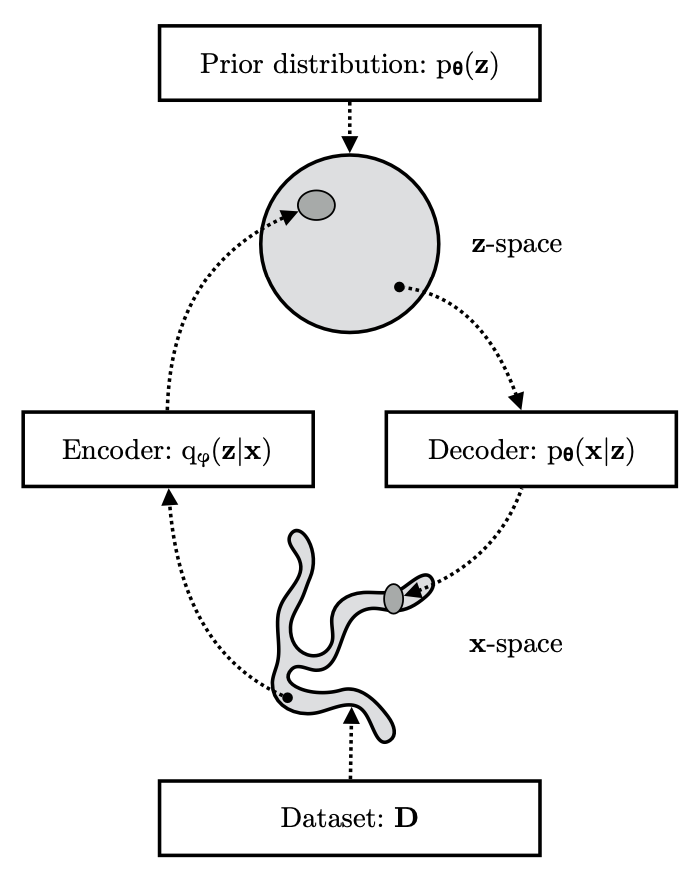{width="80%"}^[Bron: *Kingma, D. P., & Welling, M. (2019). An introduction to variational autoencoders. Foundations and Trends® in Machine Learning, 12(4), 307-392.*]

:::
::::

---

#### Variational auto-encoders

Het voornaamste verschil tussen een VAE en een reguliere auto encoder is dat tussen de *encoder* en de *decoder* er een steekproeftrekking uit de latent space (meestal normaal verdeeld) plaatsvind.

- De encoder schat de parameters van deze normaal verdeling $q(\vec{z} | \vec{x}) \sim N(\mu, \sigma^2)$. Omdat deze verdeling moet lijken op de "echte" verdeling $p(\vec{z}, \vec{x})$ moet er een *Kullback Leibner divergence* aan de *loss* toegevoegd worden, hiervoor geldt
$$
D_{KL}(q || p) = \frac{1}{2} \left(\mu^2 + \sigma^2 - \ln \sigma^2 - 1 \right)
$$
- De totale loss waar we de VAE mee trainen is nu
$$
\text{loss} = \text{Reconstruction loss} + D_{KL}(q || p)
$$


In [1]:
#| include: false
import os

os.environ["KERAS_BACKEND"] = "torch"

import keras
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import visualkeras

from keras import layers

if torch.cuda.is_available():
    print('Notebook gebruikt windows GPU')
elif torch.mps.is_available():
    print('Notebook gebruikt apple GPU')
else:
    print('Notebook gebruikt CPU')

import matplotlib.pyplot as plt

c:\Users\thezo\anaconda3\envs\ment2b2\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Notebook gebruikt CPU


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = (np.expand_dims(x_train, -1).astype("float32"))/ 255
x_test = (np.expand_dims(x_test, -1).astype("float32")) / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:

class Sampler(keras.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator()
        self.built = True

    def call(self, z_mean, z_log_var):
        batch_size = keras.ops.shape(z_mean)[0]
        z_size = keras.ops.shape(z_mean)[1]
        epsilon = keras.random.normal(
            (batch_size, z_size), seed=self.seed_generator
        )
        return z_mean + keras.ops.exp(0.5 * z_log_var) * epsilon
    
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        return self.encoder(inputs)

    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):
        z_mean, z_log_var = y_pred
        reconstruction = self.decoder(self.sampler(z_mean, z_log_var))

        reconstruction_loss = keras.ops.mean(
            keras.ops.sum(
                keras.ops.binary_crossentropy(x, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (
            1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var)
        )
        total_loss = reconstruction_loss + keras.ops.mean(kl_loss)

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return total_loss

In [4]:
latent_dim = 2

In [5]:
#| include: false

image_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(image_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(image_inputs, [z_mean, z_log_var], name="encoder")

In [6]:
#| label: encoder-summary
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

c:\Users\thezo\anaconda3\envs\ment2b2\Lib\site-packages\visualkeras\layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


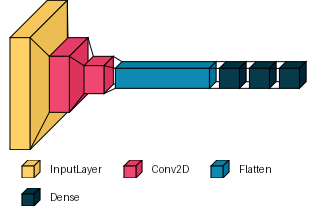

In [7]:
#| label: encoder-visual

for layer in encoder.layers:
    layer.output_shape = layer.output.shape
visualkeras.layered_view(encoder, scale_z=0.03, legend=True)

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(7 * 7 * 64, activation="relu")(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="Decoder")

In [9]:
#| label: decoder-summary

decoder.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,041 (425.94 KB)

 Trainable params: 109,041 (425.94 KB)

 Non-trainable params: 0 (0.00 B)

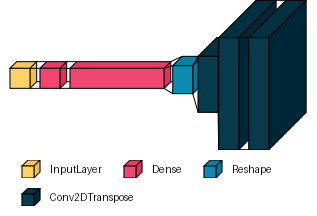

In [10]:
#| label: decoder-visual
for layer in decoder.layers:
    layer.output_shape = layer.output.shape
visualkeras.layered_view(decoder, scale_z = 0.03, legend=True)

---

#### Voorbeeld -- VAE op MNIST

We gebruiken een convolutionele encoder.


:::: {.columns}
::: {.column}

{{< contents encoder-summary >}}

:::
::: {.column}

{{< contents encoder-visual >}}

:::
::::

---

#### Voorbeeld -- VAE op MNIST

En een *transpose convolutional decoder*.


:::: {.columns}
::: {.column}

{{< contents decoder-summary >}}

:::
::: {.column}

{{< contents decoder-visual >}}

:::
::::

In [14]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: False
Number of GPUs: 0


In [ ]:
#| include: false
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
hist = vae.fit(x_train, epochs=10, validation_split = 0.2, batch_size=128)

Epoch 1/10
  2/375 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - kl_loss: 0.0014 - loss: 543.0921 - reconstruction_loss: 543.0907 

c:\Users\thezo\anaconda3\envs\ment2b2\Lib\site-packages\keras\src\backend\common\backend_utils.py:92: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


 87/375 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - kl_loss: 0.2707 - loss: 380.1209 - reconstruction_loss: 379.8501

KeyboardInterrupt: 

In [15]:
vae.save_weights('models/vae1.weights.h5')

with open('models/vae1hist.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

In [16]:
vae.load_weights('models/vae1.weights.h5')

with open('models/vae1hist.pkl', 'rb') as file:
    hist = pickle.load(file)

In [17]:
#| include: false
vae.summary()

Model: "vae_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2)) │        69,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 28, 28, 1)      │       109,041 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampler_4 (Sampler)             │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534,353 (2.04 MB)

 Trainable params: 178,117 (695.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 356,236 (1.36 MB)

---

#### Voorbeeld -- VAE op MNIST

Training (4 min.) model kan duidelijk nog beter.

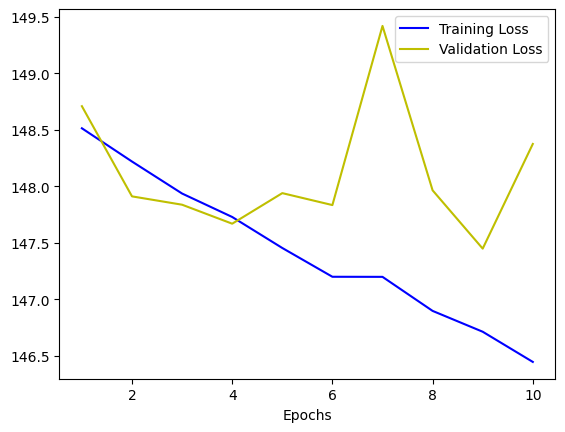

In [18]:
epochs = range(1, len(hist['loss'])+1)
plt.plot(epochs, 'loss', 'b-', data = hist, label = 'Training Loss')
plt.plot(epochs, 'val_loss', 'y-', data = hist, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [19]:
#| include: false

latent, _ = vae.encoder.predict(x_train)
xnew = vae.decoder.predict(latent)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:20 43ms/step

/Users/robertnolet/miniforge3/envs/keras3.13/lib/python3.12/site-packages/keras/src/backend/common/backend_utils.py:92: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step


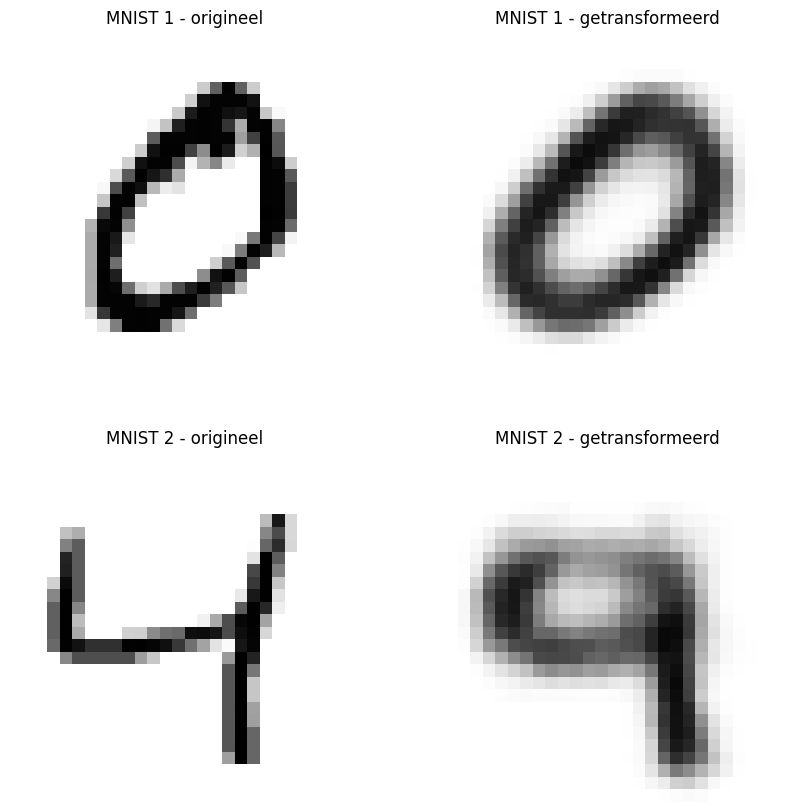

In [ ]:
#| label: mnist-reconstructie

plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(1-x_train[1].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 1 - origineel')
plt.subplot(2,2,2)
plt.imshow(1-xnew[1,:,:,0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 1 - getransformeerd')
plt.subplot(2,2,3)
plt.imshow(1-x_train[2].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 2 - origineel')
plt.subplot(2,2,4)
plt.imshow(1-xnew[2,:,:,0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 2 - getransformeerd')
plt.show()

---

#### Voorbeeld -- VAE op MNIST

:::: {.columns}
::: {.column}

Het *blurriness* probleem is een bekend fenomeen (Zie Kingma & Welling^[*Kingma, D. P., & Welling, M. (2019). An introduction to variational autoencoders. Foundations and Trends® in Machine Learning, 12(4), 307-392.*] §2.8.2) en is te verhelpen door de encoder en/of decoder flexibeler te maken.

:::
::: {.column}

{{< contents mnist-reconstructie >}}

:::
::::

---

#### Voorbeeld -- VAE op MNIST

Als we vervolgens de latent space plotten en de labels inkleuren zien we dat de VAE een redelijk duidelijk onderscheid tussen de cijfers heeft leren herkennen.

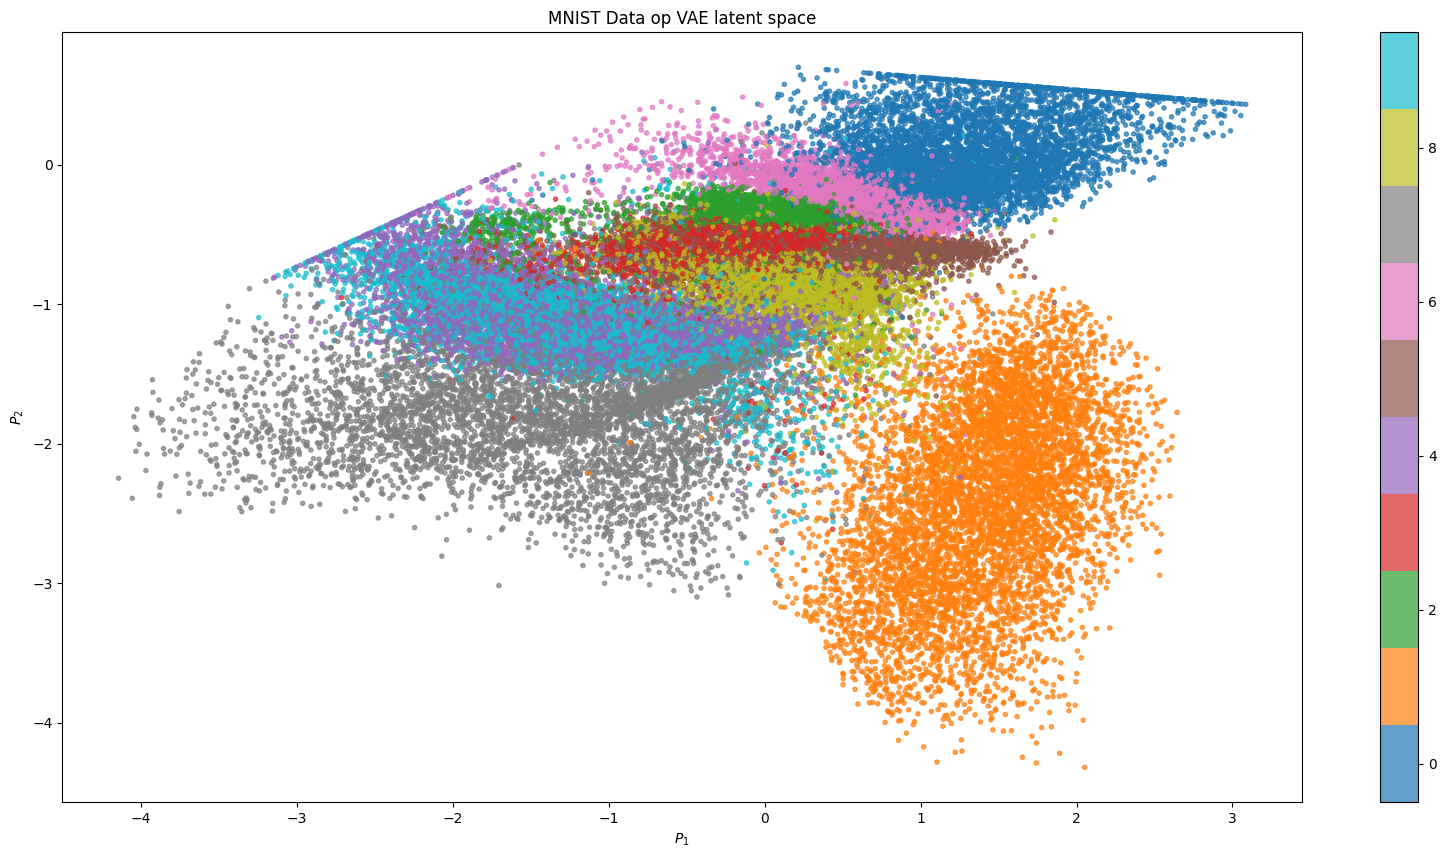

In [21]:
plt.figure(figsize=(20,10))
plt.scatter(latent[:,0], latent[:,1], c = y_train, marker='.', alpha = 0.7, cmap='tab10', vmin=-0.5, vmax=9.5)
plt.colorbar()
plt.xlabel('$P_1$')
plt.ylabel('$P_2$')
plt.title("MNIST Data op VAE latent space")
plt.show()

---

#### Voorbeeld - Genereren regendata


4e jaars project TW^[van Rijsoort, F., Janssen, M., Pruymboom, T., & Boertje, S. (2025). Extreme neerslag generator. Hogeschool van Amsterdam.] -- Genereren ruimtelijke data extreme regenbuien 

:::: {.columns}
::: {.column}

- Scenario simulatie

:::
::: {.column}

- Schade inschatting

:::
::::

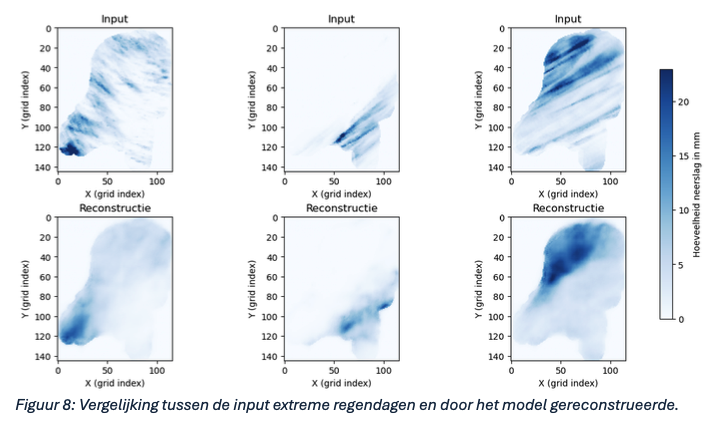

---

#### Voorbeeld - Genereren regendata

4e jaars project TW^[van Rijsoort, F., Janssen, M., Pruymboom, T., & Boertje, S. (2025). Extreme neerslag generator. Hogeschool van Amsterdam.] -- Genereren ruimtelijke data extreme regenbuien 

:::: {.columns}
::: {.column}

- Scenario simulatie

:::
::: {.column}

- Schade inschatting

:::
::::

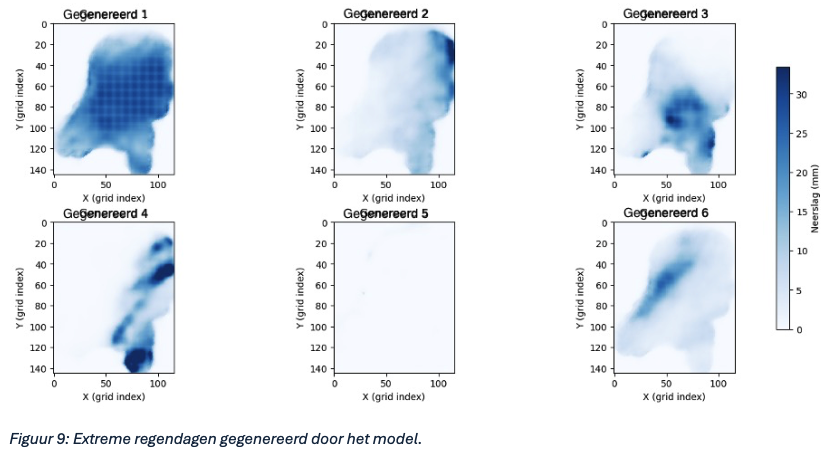

---

#### Voorbeeld: Richtingen in latent space

Een onderzoek van White^[White, T. (2016). Sampling generative networks. arXiv preprint arXiv:1609.04468.] laat zien dat verschillende richtingen in de latent space vaak overeenkomen met verschillende eigenschappen van afbeeldingen.

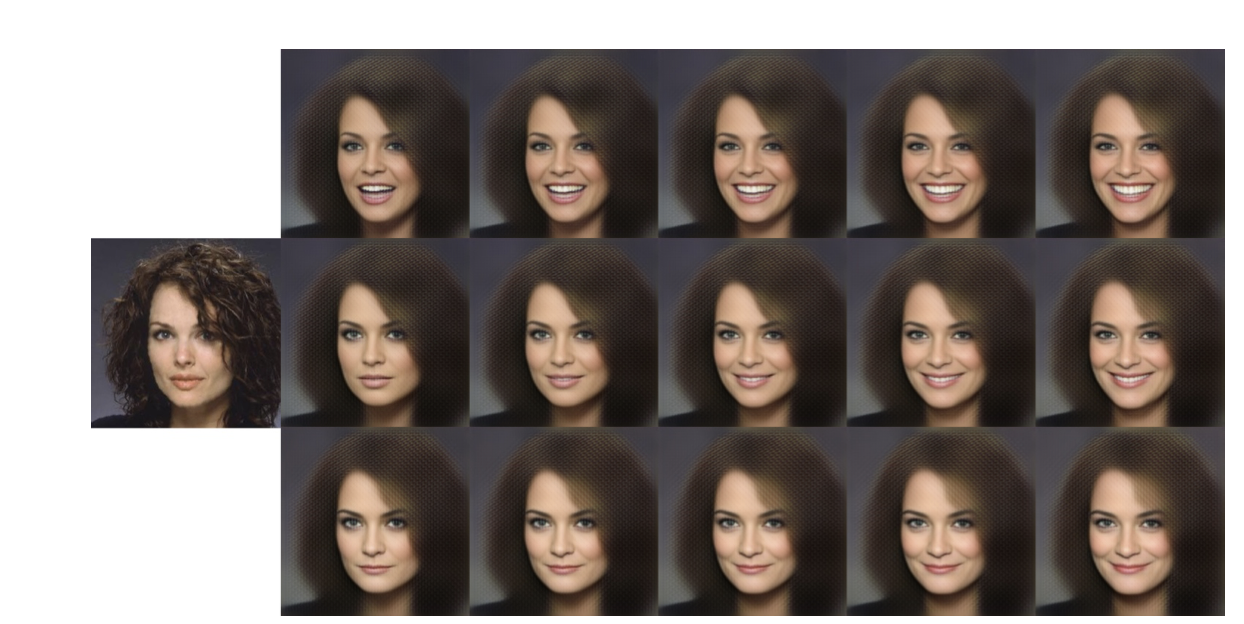{width="70%"}

(Links: invoer afbeelding, $x$-as: glimlach richting, $y$-as: open-mond richting)

---

#### Samenvatting

- VAE's zijn een heel flexibel *graphical model* dat veel lijkt op een auto encoder
  + Unsupervised
  + Structuur:
    - Encoder
    - Sampling
    - Decoder
  + De sampling procedure in de latent space heeft een regulariserend effect
- Toepassingen:
  + Beeld generatie
  + Beeld bewerking/denoising
  + Data generatie/simulatie
  + Semi-supervised learning